# Challenge Técnico MeLi

### Caso elegido:
En la vertical de pricing están interesados en dar sugerencias de descuentos para los
ítems del Marketplace. Actualmente, tienen un equipo experto en fijación de precios,
los cuales revisan ítems manualmente para encontrar si el ítem requiere un descuento
y cuál sería el descuento adecuado para generar un aumento en las ventas en el
corto plazo. Este equipo busca disminuir las cargas manuales que tienen sus
colaboradores para que puedan dedicarse a otras actividades más rentables para el
negocio.

### ¿Cómo se piensa resovler?
Una forma simple pero intuitiva de resolver el caso plateado sin tener acceso a datos reales de ventas, es analizar cómo se posicionan los precios publicados mediante API de items para uno o más productos en partícular y sugerir descuentos a aquellos que estén 'pasados' de la moda (o rango de 'moda')

#### Importación de librerías necesarias

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Request API categorías
Tiene como único objetivo tener accesibles los códigos de las categorías

In [2]:
cats = requests.get('https://api.mercadolibre.com/sites/MLA/categories')

In [21]:
#cats.json()

#### Request API Items
La idea es acceder a publicaciones de termos que estén tanto en categoría 'Deportes y Fitness' y en 'Hogar, Muebles y Jardín'.
Dado que hay un límite de 50 instancias por request, se crea un loop que permita acceder a los datos trayendo de a 50 registros.

##### Deportes y Fitness

In [4]:
cat_id = 'MLA1276'
limit = 50  # Cantidad de resultados por solicitud
offset = 0
total_results = None  # La variable para almacenar el total de resultados

# Lista para almacenar todos los resultados
all_results = []

while True:
    url = f'https://api.mercadolibre.com/sites/MLA/search?category={cat_id}&offset={offset}&limit={limit}'
    request = requests.get(url)
    items = request.json()
    
    # Verifica si la clave 'results' está presente en la respuesta
    if 'results' in items:
        # Agrega los resultados actuales a la lista
        all_results.extend(items['results'])
        
        # Actualiza el total de resultados si aún no se ha hecho
        if total_results is None:
            total_results = items['paging']['total']
        
        # Incrementa el offset
        offset += limit
        
        # Si hemos obtenido todos los resultados, salimos del bucle
        if offset >= total_results:
            break
    else:
        # No se encontró la clave 'results', asumimos que no hay más resultados
        break

# Crea un DataFrame con todos los resultados
df = pd.DataFrame(all_results)

##### Hogar

In [5]:
cat_id = 'MLA1574'
limit = 50  # Cantidad de resultados por solicitud
offset = 0
total_results = None  # La variable para almacenar el total de resultados

# Lista para almacenar todos los resultados
all_results = []

while True:
    url = f'https://api.mercadolibre.com/sites/MLA/search?category={cat_id}&offset={offset}&limit={limit}'
    request = requests.get(url)
    items = request.json()
    
    # Verifica si la clave 'results' está presente en la respuesta
    if 'results' in items:
        # Agrega los resultados actuales a la lista
        all_results.extend(items['results'])
        
        # Actualiza el total de resultados si aún no se ha hecho
        if total_results is None:
            total_results = items['paging']['total']
        
        # Incrementa el offset
        offset += limit
        
        # Si hemos obtenido todos los resultados, salimos del bucle
        if offset >= total_results:
            break
    else:
        # No se encontró la clave 'results', asumimos que no hay más resultados
        break

# Crea un DataFrame con todos los resultados
df2 = pd.DataFrame(all_results)

In [6]:
print('df: ', df.shape)
print('df2: ', df2.shape)

df:  (999, 35)
df2:  (997, 35)


#### Concatenamos ambos dataframes para unificar todo en uno y trabajar más comodamente

In [7]:
df3 = pd.concat([df, df2], ignore_index=True)

In [8]:
df3.shape

(1996, 35)

#### A partir del DF concatenado se crea uno que contenga la categoría buscada. En este caso es termos

In [9]:
termos = df3[df3['domain_id'] == 'MLA-THERMOSES']

#### Se agrega una columna 'Marca' que extrae de la columna 'attributes' la marca del producto

In [10]:
def extract_brand(attributes):
    # Verifica si 'attributes' es una lista y no está vacía
    if isinstance(attributes, list) and len(attributes) > 0:
        # Busca el primer diccionario en la lista
        first_dict = attributes[0]
        # Busca la cadena 'value_name' en el diccionario y extrae el valor
        if 'value_name' in first_dict:
            return first_dict['value_name']
    
    return None

# Aplica la función a la columna 'attributes' y crea la columna 'Marca'
termos = termos.copy()
termos['Marca'] = termos['attributes'].apply(extract_brand)

#### Ploteamos la cantidad de publicaciones por rango de precios para cada marca

C:\Users\sherbes\AppData\Local\Temp\ipykernel_8620\1823937142.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_mode_freq = termos.groupby(['Marca', 'price_range']).size().reset_index(name='count')


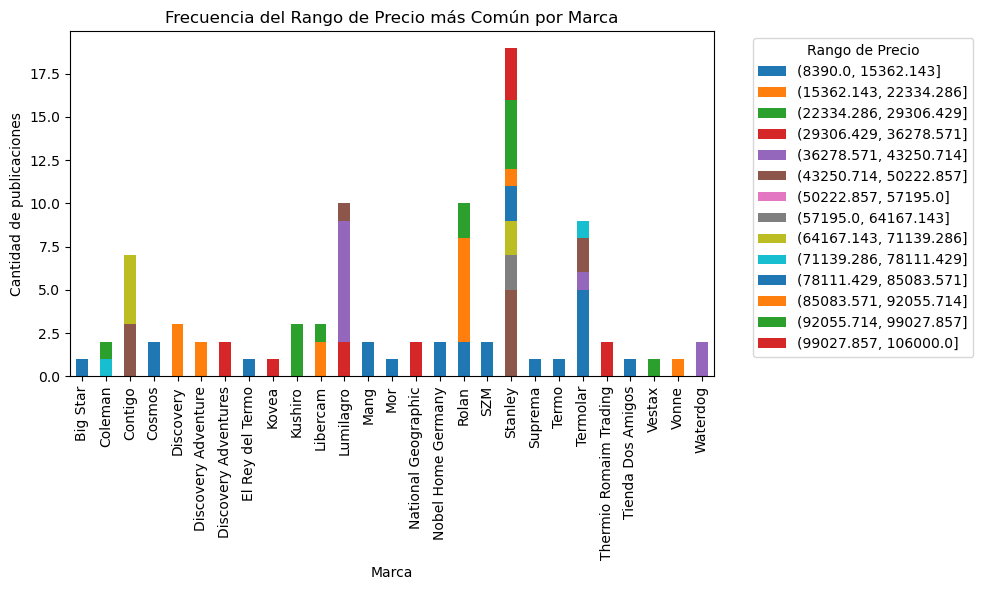

In [11]:
# Define los bins de precios
bins = np.linspace(termos['price'].min(), termos['price'].max(), num=15)  # Ajusta el número de bins como sea necesario

# Crea una nueva columna en termos que indica el bin de cada precio
termos['price_range'] = pd.cut(termos['price'], bins)

# Agrupa por 'Marca' y 'price_range' y encuentra la moda (rango de precio más frecuente)
price_mode = termos.groupby('Marca')['price_range'].agg(lambda x: x.value_counts().index[0])

# Ahora calcula la frecuencia de la moda para cada marca
price_mode_freq = termos.groupby(['Marca', 'price_range']).size().reset_index(name='count')

# Asumiendo que 'price_mode_freq' es tu DataFrame que contiene las marcas y las frecuencias de los rangos de precios
sorted_price_mode_freq = price_mode_freq.sort_values('Marca')

# Ahora graficamos usando el DataFrame ordenado
sorted_price_mode_freq.pivot(index='Marca', columns='price_range', values='count').plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Marca')
plt.ylabel('Cantidad de publicaciones')
plt.title('Frecuencia del Rango de Precio más Común por Marca')
plt.legend(title='Rango de Precio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Para asegurar que la leyenda no quede encima del gráfico
plt.show()

#### Buscando y sugiriendo descuentos

Mediante el código siguiente lo que hacemos es buscar aquellas publicaciones de una marca específica que estén fuera del rango más poblado de precios.
Utilizando una especie de 'reversión a la media' sugerimos un descuento para aquellas publicaciones que las lleve al promedio de dicho rango. 
Ésta es una práctica común en retail y B2C de consumo masivo.

In [19]:
# Definimos la marca deseada
marca_deseada = 'Rolan'  # Cambia esto por la marca que quieras analizar

# Filtramos
marca_termos = termos[termos['Marca'] == marca_deseada]

# Encontrar el rango de precio más común para la marca deseada
common_range = marca_termos['price_range'].value_counts().idxmax()

# Calcular la media de precios dentro del rango más común
mean_price_in_range = marca_termos[marca_termos['price_range'] == common_range]['price'].mean()

# Filtrar las publicaciones de la marca deseada con precios fuera del rango hacia arriba
above_range = marca_termos[(marca_termos['price'] > common_range.right) & (marca_termos['price'] != common_range)]

# Copiar el DataFrame original para preservar todas las columnas
result = above_range.copy()

# Calcular el descuento sugerido para cada publicación
result['suggested_discount'] = result['price'] - mean_price_in_range

In [20]:
result.head()

,id,title,condition,thumbnail_id,catalog_product_id,listing_type_id,permalink,buying_mode,site_id,category_id,...,catalog_listing,discounts,promotions,inventory_id,variation_filters,variations_data,differential_pricing,Marca,price_range,suggested_discount
404,MLA1393485735,Termo Rolan Mate Listo Autocebante 750ml Negro,new,985686-MLA54848597795_042023,MLA22491287,gold_special,https://www.mercadolibre.com.ar/termo-rolan-ma...,buy_it_now,MLA,MLA47769,...,True,None,[],None,NaN,NaN,NaN,Rolan,"(22334.286, 29306.429]",5450.07
1847,MLA1393485735,Termo Rolan Mate Listo Autocebante 750ml Negro,new,985686-MLA54848597795_042023,MLA22491287,gold_special,https://www.mercadolibre.com.ar/termo-rolan-ma...,buy_it_now,MLA,MLA47769,...,True,None,[],None,NaN,NaN,NaN,Rolan,"(22334.286, 29306.429]",5450.07


#### Exportamos el DF de descuentos sugeridos como excel para que el equipo de pricing pueda verlo fácilmente

In [ ]:
#result.to_excel('descuentos_sugeridos.xlsx', index=False)